# Meta analyses

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import functions as fun
from nistats import thresholding
import numpy as np
import nibabel as nib
import nilearn
from nilearn import masking, plotting
import matplotlib.pyplot as plt

template = nilearn.datasets.load_mni152_template()
affine = template.affine

level = .05
height_control = 'fdr'
cluster_threshold = 1
sample_size=119

cut_coords=(0, 0, 0)

Get the paths for the unthresholded image for each analysis team, for the given hypothesis.

In [2]:
input_dir = '../data-narps/proc/'
img_paths = fun.get_data_paths(input_dir)

For now, select the first N studies. 

In [3]:
# N_img = 3
# img_paths = img_paths[:N_img]

Convert the images to the dataset directory that is readable by NiMARE, the meta-analysis package. 

In [4]:
ds_dict = fun.extract_from_paths(img_paths, data=['path', 'coord'], sample_size=sample_size, 
                    level=level, height_control=height_control, cluster_threshold=cluster_threshold)

/opt/miniconda-latest/envs/neuro_py36/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/miniconda-latest/envs/neuro_py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro_py36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


## Coordinate-based meta-analysis
Using Activation Likelihood Estimation

In [5]:
# Unthresholded ALE image
img_ale, img_p, img_z = fun.run_ALE(ds_dict)

INFO:nimare.dataset:Shared path detected: "/home/neuro/test/data-narps/proc/hypo1_unthresh_"


In [6]:
# Thresholded ALE image
img_ale_thr = thresholding.map_threshold(img_ale, level=level, 
                                           height_control=height_control,
                                           cluster_threshold=cluster_threshold)[0]

## Image-based meta-analysis
Using a mixed-effects linear model

In [7]:
# Unthresholded MFX image
img_t_MFX = fun.run_MFX_GLM(ds_dict)

INFO:nimare.dataset:Shared path detected: "/home/neuro/test/data-narps/proc/hypo1_unthresh_"


191028-22:26:43,25 nipype.interface INFO:
	 stdout 2019-10-28T22:26:43.025399:Log directory is: stats


INFO:nipype.interface:stdout 2019-10-28T22:26:43.025399:Log directory is: stats


191028-22:26:43,28 nipype.interface INFO:
	 stdout 2019-10-28T22:26:43.028376:Setting up:


INFO:nipype.interface:stdout 2019-10-28T22:26:43.028376:Setting up:


191028-22:26:44,907 nipype.interface INFO:
	 stdout 2019-10-28T22:26:44.907205:ntptsing=37.000000 


INFO:nipype.interface:stdout 2019-10-28T22:26:44.907205:ntptsing=37.000000 


191028-22:26:44,908 nipype.interface INFO:
	 stdout 2019-10-28T22:26:44.907205:


INFO:nipype.interface:stdout 2019-10-28T22:26:44.907205:


191028-22:26:44,910 nipype.interface INFO:
	 stdout 2019-10-28T22:26:44.907205:evs_group=1.000000 


INFO:nipype.interface:stdout 2019-10-28T22:26:44.907205:evs_group=1.000000 


191028-22:26:44,911 nipype.interface INFO:
	 stdout 2019-10-28T22:26:44.907205:


INFO:nipype.interface:stdout 2019-10-28T22:26:44.907205:


191028-22:26:44,912 nipype.interface INFO:
	 stdout 2019-10-28T22:26:44.912710:No f contrasts


INFO:nipype.interface:stdout 2019-10-28T22:26:44.912710:No f contrasts


191028-22:26:45,190 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.190611:


INFO:nipype.interface:stdout 2019-10-28T22:26:45.190611:


191028-22:26:45,193 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.190611:WARNING: The passed in varcope file, /home/neuro/test/analyses/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


INFO:nipype.interface:stdout 2019-10-28T22:26:45.190611:WARNING: The passed in varcope file, /home/neuro/test/analyses/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


191028-22:26:45,199 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.199057:nevs=1


INFO:nipype.interface:stdout 2019-10-28T22:26:45.199057:nevs=1


191028-22:26:45,201 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.199057:ntpts=37


INFO:nipype.interface:stdout 2019-10-28T22:26:45.199057:ntpts=37


191028-22:26:45,203 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.199057:ngs=1


INFO:nipype.interface:stdout 2019-10-28T22:26:45.199057:ngs=1


191028-22:26:45,208 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.199057:nvoxels=227461


INFO:nipype.interface:stdout 2019-10-28T22:26:45.199057:nvoxels=227461


191028-22:26:45,258 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.258797:Running:


INFO:nipype.interface:stdout 2019-10-28T22:26:45.258797:Running:


191028-22:26:45,260 nipype.interface INFO:
	 stdout 2019-10-28T22:26:45.258797:nmaskvoxels=227461


INFO:nipype.interface:stdout 2019-10-28T22:26:45.258797:nmaskvoxels=227461


191028-22:27:26,331 nipype.interface INFO:
	 stdout 2019-10-28T22:27:26.330945: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


INFO:nipype.interface:stdout 2019-10-28T22:27:26.330945: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


191028-22:27:26,335 nipype.interface INFO:
	 stdout 2019-10-28T22:27:26.335255:nmaskvoxels=227461


INFO:nipype.interface:stdout 2019-10-28T22:27:26.335255:nmaskvoxels=227461


191028-22:27:26,336 nipype.interface INFO:
	 stdout 2019-10-28T22:27:26.335255:Saving results


INFO:nipype.interface:stdout 2019-10-28T22:27:26.335255:Saving results


191028-22:27:31,535 nipype.interface INFO:
	 stdout 2019-10-28T22:27:31.535017:


INFO:nipype.interface:stdout 2019-10-28T22:27:31.535017:


191028-22:27:31,536 nipype.interface INFO:
	 stdout 2019-10-28T22:27:31.535017:Log directory was: stats


INFO:nipype.interface:stdout 2019-10-28T22:27:31.535017:Log directory was: stats


191028-22:27:32,804 nipype.interface INFO:
	 stdout 2019-10-28T22:27:32.804244:DLH 0.0936933


INFO:nipype.interface:stdout 2019-10-28T22:27:32.804244:DLH 0.0936933


191028-22:27:32,806 nipype.interface INFO:
	 stdout 2019-10-28T22:27:32.804244:VOLUME 227461


INFO:nipype.interface:stdout 2019-10-28T22:27:32.804244:VOLUME 227461


191028-22:27:32,807 nipype.interface INFO:
	 stdout 2019-10-28T22:27:32.804244:RESELS 49.8037


INFO:nipype.interface:stdout 2019-10-28T22:27:32.804244:RESELS 49.8037


191028-22:27:33,69 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.068936:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-10-28T22:27:33.068936:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191028-22:27:33,71 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.068936:1	52335	0	153	9.26	-44	-50	-10	0.848	-36.8	12.1	4.21	-46	-16	52	0.904


INFO:nipype.interface:stdout 2019-10-28T22:27:33.068936:1	52335	0	153	9.26	-44	-50	-10	0.848	-36.8	12.1	4.21	-46	-16	52	0.904


191028-22:27:33,809 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191028-22:27:33,811 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:5	61604	0	171	9.08	14	34	52	-7.66	-3.87	28.5	3.81	-42	-26	64	1.25


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:5	61604	0	171	9.08	14	34	52	-7.66	-3.87	28.5	3.81	-42	-26	64	1.25


191028-22:27:33,812 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:4	3316	2.53e-23	22.6	6.84	32	-78	-38	24.2	-66.4	-33.3	2.47	20	-48	-20	0.975


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:4	3316	2.53e-23	22.6	6.84	32	-78	-38	24.2	-66.4	-33.3	2.47	20	-48	-20	0.975


191028-22:27:33,813 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:3	2699	3.66e-20	19.4	8.07	62	-22	-20	59.5	-30.1	-14.2	2.26	62	-22	-22	0.913


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:3	2699	3.66e-20	19.4	8.07	62	-22	-20	59.5	-30.1	-14.2	2.26	62	-22	-22	0.913


191028-22:27:33,814 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:2	670	3.58e-07	6.45	5.32	-18	-84	-32	-27.8	-76.5	-37.5	1.63	-18	-84	-32	0.852


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:2	670	3.58e-07	6.45	5.32	-18	-84	-32	-27.8	-76.5	-37.5	1.63	-18	-84	-32	0.852


191028-22:27:33,815 nipype.interface INFO:
	 stdout 2019-10-28T22:27:33.809225:1	457	2.94e-05	4.53	5.2	2	-36	-16	-8.47	-35	-24.7	1.71	-22	-50	-26	0.601


INFO:nipype.interface:stdout 2019-10-28T22:27:33.809225:1	457	2.94e-05	4.53	5.2	2	-36	-16	-8.47	-35	-24.7	1.71	-22	-50	-26	0.601
INFO:nimare.meta.ibma:Cleaning up...
/opt/miniconda-latest/envs/neuro_py36/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [21]:
# Thresholded MFX image
img_t_MFX_thr = thresholding.map_threshold(img_t_MFX, level=level,
                                           height_control=height_control,
                                           cluster_threshold=cluster_threshold)[0]

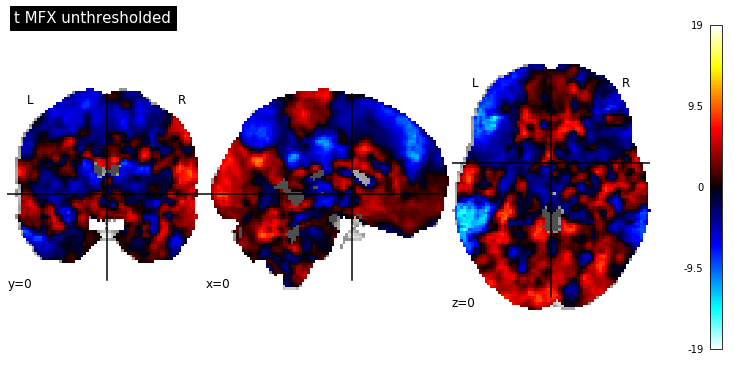

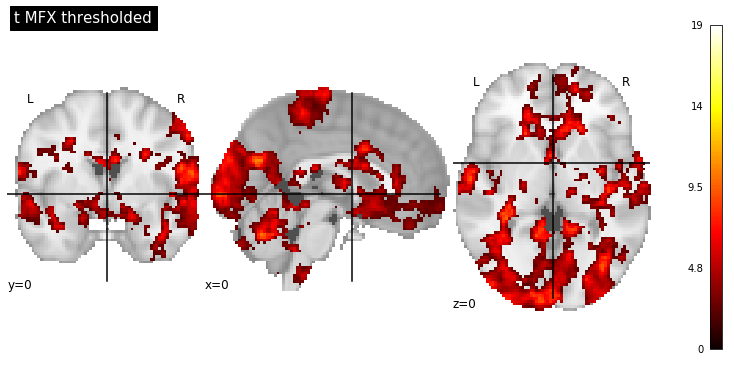

In [22]:
meta_analysis = { 
    #'ALE': img_ale,
    #'ALE thresholded': img_ale_thr,
    't MFX unthresholded': img_t_MFX,
    't MFX thresholded': img_t_MFX_thr,
}
for name, img in meta_analysis.items():
    plotting.plot_stat_map(img, title=name, cut_coords=cut_coords,
                          figure=plt.figure(figsize=(10,5)))   
    plt.savefig('../figures/results_%s.png' %name.replace(' ', '-'))